# Classification with Deep Neural Networks

## Load MNIST Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from torchvision import datasets, transforms

In [3]:
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)


In [4]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28, 28)
    
    plt.imshow(img, cmap='gray')
    plt.show()

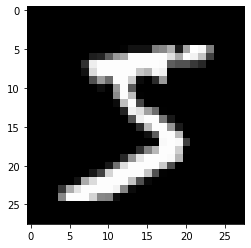

In [5]:
plot(train.data[0])

In [18]:
x = train.data.float() / 255.0
y = train.targets

x = x.view(x.size(0), -1)  ## reshape tensor
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print(f"Input_size: {input_size}, output_size: {output_size}")

torch.Size([60000, 784]) torch.Size([60000])
Input_size: 784, output_size: 10


---
## Train/ Valid / Test ratio

### Preparing data sets

In [35]:
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = test.data.size(0)

cnts = [train_cnt, valid_cnt]

print(f"Train {train_cnt} / Valid {valid_cnt} / Test {test_cnt} samples")

## Shuffle before split data.

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

## split data.

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

## Add test data set 

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())



Train 48000 / Valid 12000 / Test 10000 samples
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


---
## Build Model & Optimizer

In [36]:
model = nn.Sequential(
    nn.Linear(input_size, 500), ## 784 => 500
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1),
)

model

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax()
)

In [37]:
crit = nn.NLLLoss()

In [38]:
optimizer = optim.Adam(model.parameters())

---
## Move to GPU if it is available

In [39]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [40]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

---
## Train

In [41]:
## define configuration

n_epochs = 1000
batch_size = 256
print_interval = 10

In [42]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [54]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss += float(loss)
        
    train_loss = train_loss / len(x_)
    
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i)
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
        
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (i + 1) % print_interval == 0:
        print(f"Epch {i + 1}: train_loss={train_loss:.4f} valid_loss={valid_loss:.4f}\
         lowest_loss={lowest_loss:.4f}")
    
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print(f"There is no improvement during last {early_stop} epochs")
            break
            
print(f"The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.4f}")
model.load_state_dict(best_model)

Epch 10: train_loss=0.0227 valid_loss=0.1021         lowest_loss=0.0879
Epch 20: train_loss=0.0153 valid_loss=0.1050         lowest_loss=0.0879
Epch 30: train_loss=0.0081 valid_loss=0.1091         lowest_loss=0.0879
Epch 40: train_loss=0.0061 valid_loss=0.1193         lowest_loss=0.0879
Epch 50: train_loss=0.0059 valid_loss=0.1308         lowest_loss=0.0879
There is no improvement during last 50 epochs
The best validation loss from epoch 5: 0.0879


<All keys matched successfully>

---
## Loss History

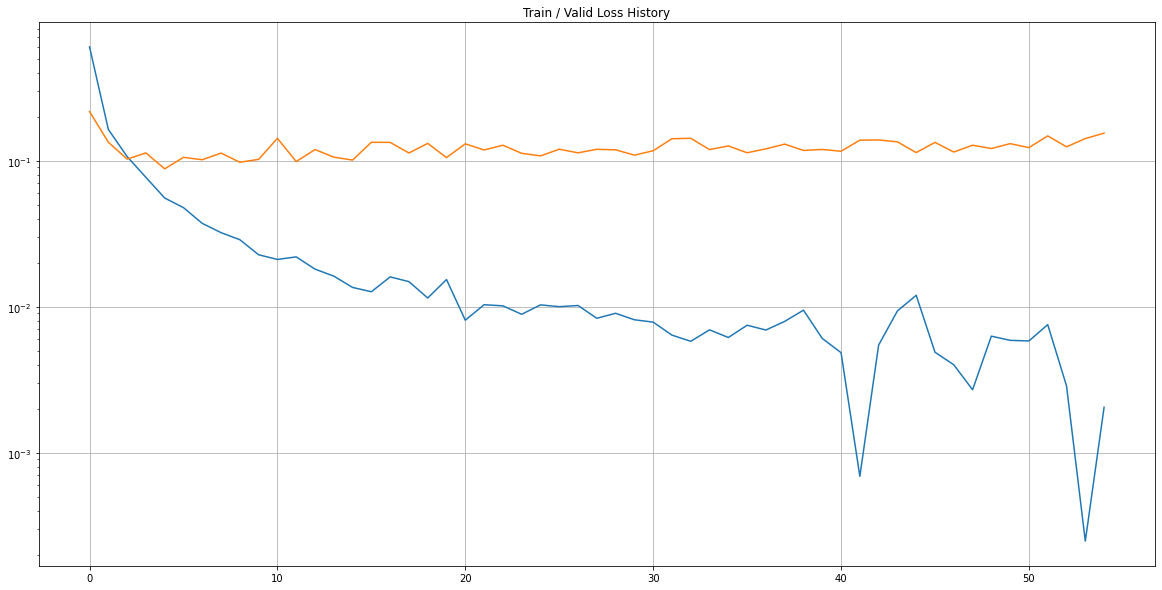

In [55]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)

plt.yscale('log')
plt.show()

---
## Result - Test model

In [56]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i)
        
        test_loss += loss
        
        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print(f"Test loss: {test_loss:.4f}")

Test loss: 0.0838


In [67]:
## Accuracy score

correct_cnt = (y[-1] == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print(f"Accuracy: {correct_cnt / total_cnt:.4f}")

Accuracy: 0.9722


In [68]:
from sklearn.metrics import confusion_matrix

In [69]:
## Confusion matrix

pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=[f"true {i}" for i in range(10)],
             columns=[f"pred {i}" for i in range(10)])

,pred 0,pred 1,pred 2,pred 3,pred 4,pred 5,pred 6,pred 7,pred 8,pred 9
true 0,966,0,1,2,1,2,3,0,1,4
true 1,0,1123,0,4,0,2,3,0,3,0
true 2,3,2,998,9,5,1,7,2,4,1
true 3,0,0,5,993,0,3,0,5,2,2
true 4,2,1,1,0,957,1,6,4,0,10
true 5,2,0,0,24,1,857,4,0,2,2
true 6,4,1,0,0,3,4,944,0,2,0
true 7,1,4,12,9,1,0,0,997,0,4
true 8,3,0,6,19,7,13,4,4,915,3
true 9,4,3,0,12,8,2,1,6,1,972
